In [11]:
# from sklearn.metrics import ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
#
# def plot_confusion_matrix(y_obs, y_exp):
#     cm = confusion_matrix(y_obs, y_exp)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot(cmap='viridis')
#     plt.title("Confusion Matrix")
#     plt.show()

Accuracy: 0.9912280701754386
Confusion Matrix:
 [[565   0]
 [  5   0]]


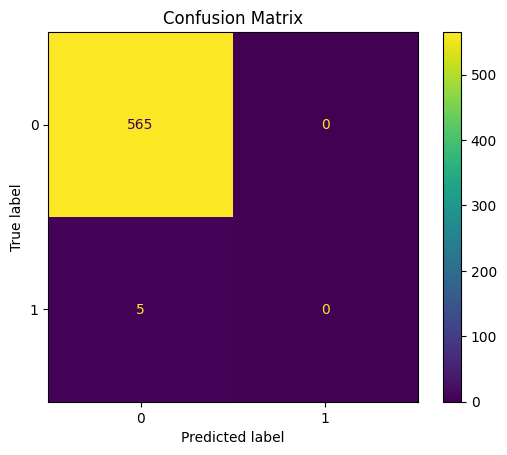

In [12]:
from exo_toolkit import *

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import polars as pl
from sklearn.metrics import precision_recall_curve
import numpy as np

train_data = pd.read_csv('data/exoTrain.csv')
test_data = pd.read_csv('data/exoTest.csv')

# Separate features & labels
X_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
y_test = test_data.iloc[:, 0]

# print(y_train.value_counts())
# print(y_test.value_counts())

# Map labels to binary: 1 → 0, 2 → 1
y_train = y_train.map({1: 0, 2: 1})
y_test = y_test.map({1: 0, 2: 1})

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# print(y_train.value_counts())
# print(pd.Series(y_train_resampled).value_counts())

# Train
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

## Optimal Threshold

In [13]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# find optimal threshold
y_prob = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = np.nan_to_num(2 * (precision * recall) / (precision + recall))  # Handle NaN values
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_prob >= optimal_threshold)

print("Threshold:", optimal_threshold)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
# print("\nClassification:\n", classification_report(y_test, y_pred, zero_division=1))

Threshold: 0.15
Confusion Matrix:
 [[539  26]
 [  2   3]]
Accuracy: 0.9508771929824561


C:\Users\User\AppData\Local\Temp\ipykernel_26316\973320972.py:7: RuntimeWarning: invalid value encountered in divide
  f1_scores = np.nan_to_num(2 * (precision * recall) / (precision + recall))  # Handle NaN values


Threshold: 0.1414
Accuracy: 0.9508771929824561


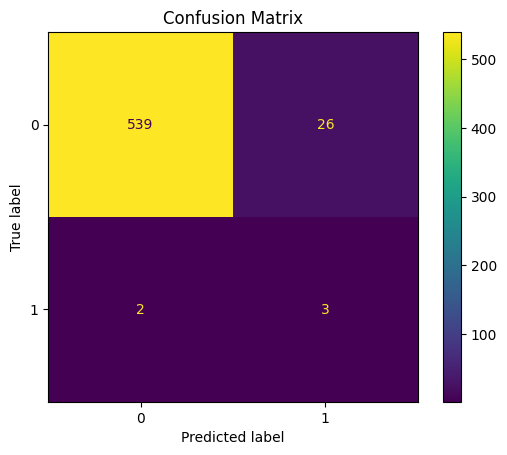

In [14]:
# Predict probs
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Apply threshold
threshold = 0.1414
y_pred_adjusted = (y_prob >= threshold)

# Evaluate
print("Threshold:", threshold)
print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
plot_confusion_matrix(y_test, y_pred_adjusted)

## Polars Test

C:\Users\User\AppData\Local\Temp\ipykernel_26316\4037342118.py:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  y_train = y_train.map_elements(lambda x: {1: 0, 2: 1}.get(x, x))
C:\Users\User\AppData\Local\Temp\ipykernel_26316\4037342118.py:12: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  y_test = y_test.map_elements(lambda x: {1: 0, 2: 1}.get(x, x))


Accuracy: 0.9912280701754386
Confusion Matrix:
 [[565   0]
 [  5   0]]


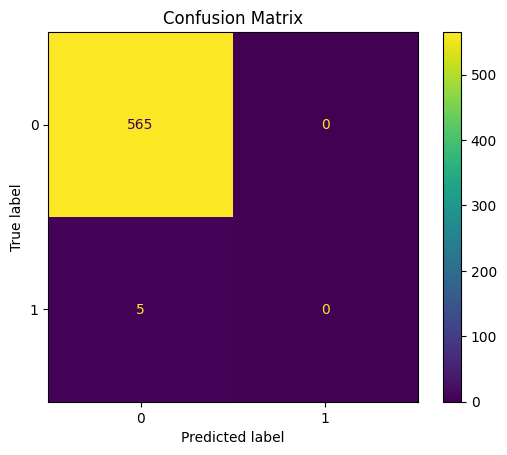

In [15]:
import polars as pl

train_data = pl.read_csv('data/exoTrain.csv')
test_data = pl.read_csv('data/exoTest.csv')

X_train = train_data[:, 1:]
y_train = train_data[:, 0]
X_test = test_data[:, 1:]
y_test = test_data[:, 0]

y_train = y_train.map_elements(lambda x: {1: 0, 2: 1}.get(x, x))
y_test = y_test.map_elements(lambda x: {1: 0, 2: 1}.get(x, x))


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

## Time Series

In [16]:
"""from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested  # noqa
from sklearn.metrics import accuracy_score
import pandas as pd

# Load data
train_data = pd.read_csv('data/exoTrain.csv')
test_data = pd.read_csv('data/exoTest.csv')

# Extract features and labels
x_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0]
x_test = test_data.iloc[:, 1:]
y_test = test_data.iloc[:, 0]

# Convert feature data to nested format
x_train_nested = from_2d_array_to_nested(x_train)
x_test_nested = from_2d_array_to_nested(x_test)

# Train classifier
clf = TimeSeriesForestClassifier(random_state=42)
clf.fit(x_train_nested, y_train)

# Predict and calculate accuracy
y_pred = clf.predict(x_test_nested)
accuracy = accuracy_score(y_test, y_pred)

# print(f"Accuracy: {accuracy}")

print("*"*50)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("*"*50)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("*"*50)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("-"*50)
"""
useless

'from sktime.classification.interval_based import TimeSeriesForestClassifier\nfrom sktime.datatypes._panel._convert import from_2d_array_to_nested  # noqa\nfrom sklearn.metrics import accuracy_score\nimport pandas as pd\n\n# Load data\ntrain_data = pd.read_csv(\'data/exoTrain.csv\')\ntest_data = pd.read_csv(\'data/exoTest.csv\')\n\n# Extract features and labels\nx_train = train_data.iloc[:, 1:]\ny_train = train_data.iloc[:, 0]\nx_test = test_data.iloc[:, 1:]\ny_test = test_data.iloc[:, 0]\n\n# Convert feature data to nested format\nx_train_nested = from_2d_array_to_nested(x_train)\nx_test_nested = from_2d_array_to_nested(x_test)\n\n# Train classifier\nclf = TimeSeriesForestClassifier(random_state=42)\nclf.fit(x_train_nested, y_train)\n\n# Predict and calculate accuracy\ny_pred = clf.predict(x_test_nested)\naccuracy = accuracy_score(y_test, y_pred)\n\n# print(f"Accuracy: {accuracy}")\n\nprint("*"*50)\nprint("Accuracy:", accuracy_score(y_test, y_pred))\nprint("*"*50)\nprint("\nClassifica